In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
# Load the dataset
df = pd.read_csv('berau_weather.csv')
df.head()

,Unnamed: 0,Date,Day,Temp,Wind,Weather
0,0,2015-01-01,1,26.6,53.2,Sunny
1,1,2015-01-02,2,26.6,53.2,Sunny
2,2,2015-01-03,3,26.6,53.2,Rain
3,3,2015-01-04,4,26.6,53.2,Cloudy
4,4,2015-01-05,5,26.6,53.2,Rain


In [3]:
# Extract the features and target variable
data = df[['Date', 'Weather']]  # Select 'Date' and 'Weather' columns
data = data.set_index('Date')

# Create numerical labels for the categorical variable 'Weather'
labels = data['Weather'].unique()
label_mapping = {label: i for i, label in enumerate(labels)}
data['Weather_Label'] = data['Weather'].map(label_mapping)

# Min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Weather_Label']])

In [4]:
# Split the dataset into features (X) and target variable (y)
X = scaled_data[:-1]
y = scaled_data[1:]

In [5]:
# Convert target variable to categorical format
num_classes = len(labels)
y_categorical = to_categorical(y.argmax(axis=1), num_classes=num_classes)

In [6]:
# Split the dataset into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

train_indices, test_indices = [], []

for train_index, test_index in tscv.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Use the indices from the first split to divide the dataset
train_index = train_indices[0]
test_index = test_indices[0]

X_train = X[train_index]
X_test = X[test_index]
y_train_categorical = y_categorical[train_index]
y_test_categorical = y_categorical[test_index]

In [7]:
# Create the LSTM model
model = Sequential([
    LSTM(128, input_shape=(4, 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 70,787
Trainable params: 70,787
Non-trainable params: 0
_________________________________________________________________


In [8]:
# callback
auto_stop_learn = EarlyStopping(
    monitor = 'loss',
    min_delta = 0,
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical),
                    epochs=100, batch_size=128, callbacks=[auto_stop_learn], verbose=1)

Epoch 1/100
2/2 [==============================] - 4s 617ms/step - loss: 1.0310 - accuracy: 1.0000 - val_loss: 0.8563 - val_accuracy: 1.0000
Epoch 2/100
2/2 [==============================] - 0s 55ms/step - loss: 0.7989 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 0.5175 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.2537 - accuracy: 1.0000 - val_loss: 0.1088 - val_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0934 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 0s 49ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 8/100
2/2 [==

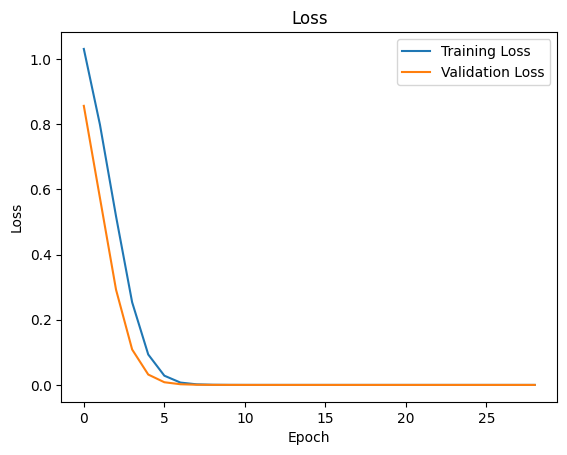

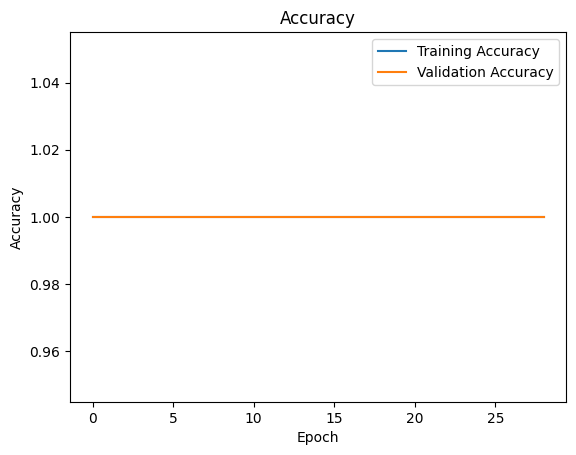

In [10]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
model.save("weather_berau.h5")

In [12]:
import datetime
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("weather_berau.h5")

def predict_weather(year, month, day):
    # Convert date to datetime object
    input_date = datetime.date(year, month, day)

    # Get the reference date
    reference_date = datetime.date(2015, 1, 1)

    # Get the number of days since the reference date
    delta_days = (input_date - reference_date).days

    # Create a sequence of four consecutive delta days
    input_sequence = np.repeat(delta_days, 4)

    # Reshape the input data into the shape expected by the model
    input_data = input_sequence.reshape((1, 4, 1))

    # Predict the weather
    predicted_weather = model.predict(input_data)[0]

    # Get the index of the weather with the highest probability
    predicted_weather_index = np.argmax(predicted_weather)

    # Get the label of the weather corresponding to the index
    predicted_weather_label = labels[predicted_weather_index]

    return predicted_weather_label

# Example call to the function
year = 200
month = 12
day = 30

predicted_weather = predict_weather(year, month, day)

print(predicted_weather)


1/1 [==============================] - 0s 488ms/step
Sunny
